In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

### Import CSV

In [36]:
df = pd.read_csv('original.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [37]:
dff = pd.read_csv('filtered.csv')
dff.head()

,battery_power,fc,int_memory,mobile_wt,pc,px_height,px_width,ram,three_g,sc_w,price_range
0,842,1,7,188,2,20,756,2549,0,7,1
1,1021,0,53,136,6,905,1988,2631,1,3,2
2,563,2,41,145,6,1263,1716,2603,1,2,2
3,615,0,10,131,9,1216,1786,2769,1,8,2
4,1821,13,44,141,14,1208,1212,1411,1,2,1


### Hyperparameter Variables

In [38]:
dtParams = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
rfParams = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],}
svmParams = {'C': [0.1, 1, 10, 100, 1000, 10000]}

In [39]:
# Array for evaluation of models
MODEL = []
TEST = []
TRAIN = []
def eval(model,test,train):
    MODEL.append(model)
    TEST.append(round(test,2))
    TRAIN.append(round(train,2))

## Original Dataset

In [40]:
# Separate the data into features and target variable
x = df.drop('price_range', axis=1)
y = df['price_range']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1386, 20), (594, 20), (1386,), (594,))

### Decission Tree

In [41]:
start = time.time()
grid =  GridSearchCV(DecisionTreeClassifier(), dtParams, cv=5, verbose = 1, n_jobs = -1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameter {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 6}
Best Score 0.8355011297820949
Time Elapsed:  9.58


In [42]:
# Train the model with the best parameters
dtBest = grid.best_estimator_
dtBest.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=6)

In [43]:
# Predict on test data
y_dt = dtBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_dt], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.90      0.95      0.92       158
           1       0.84      0.77      0.80       155
           2       0.71      0.80      0.75       129
           3       0.92      0.85      0.88       152

    accuracy                           0.84       594
   macro avg       0.84      0.84      0.84       594
weighted avg       0.85      0.84      0.84       594



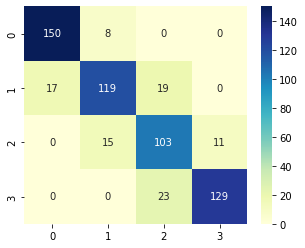

In [44]:
# Accuracy of the model
dtTrain = dtBest.score(x_train, y_train)*100
dtTest = dtBest.score(x_test, y_test)*100
dtCon = confusion_matrix(y_test, y_dt)
print(classification_report(y_test, y_dt))
plt.figure(figsize=(5,4))
sns.heatmap(dtCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Decision Tree',dtTest,dtTrain)

### Random Forest

In [45]:
start = time.time()
grid =  GridSearchCV(RandomForestClassifier(), rfParams, cv=5, verbose = 1, n_jobs = -1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameter {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}
Best Score 0.8665194919876373
Time Elapsed:  149.23


In [46]:
# Train the model with the best parameters
rfBest = grid.best_estimator_
rfBest.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3)

In [47]:
# Predict on test data
y_rf = rfBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_rf], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       158
           1       0.83      0.81      0.82       155
           2       0.77      0.80      0.78       129
           3       0.95      0.89      0.92       152

    accuracy                           0.87       594
   macro avg       0.86      0.86      0.86       594
weighted avg       0.87      0.87      0.87       594



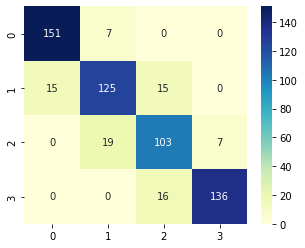

In [48]:
# Accuracy of the model
rfTrain = rfBest.score(x_train, y_train)*100
rfTest = rfBest.score(x_test, y_test)*100
rfCon = confusion_matrix(y_test, y_rf)
print(classification_report(y_test, y_rf))
plt.figure(figsize=(5,4))
sns.heatmap(rfCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Random Forest',rfTest,rfTrain)


### Support Vector Machine

In [49]:
start = time.time()
grid = GridSearchCV(SVC(), svmParams, verbose = 1,n_jobs=-1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameter {'C': 1000}
Best Score 0.9610368023270915
Time Elapsed:  0.37


In [50]:
# Accuracy of the model
svmBest = grid.best_estimator_
svmBest.fit(x_train, y_train)

SVC(C=1000)

In [51]:
# Predict on test data
y_svm = svmBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_svm], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.96      0.97      0.96       155
           2       0.97      0.96      0.96       129
           3       0.98      0.99      0.99       152

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594



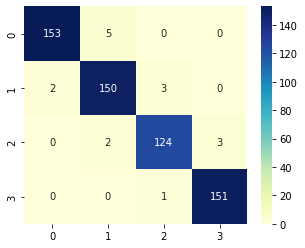

In [52]:
# Accuracy of the model
svmTrain = svmBest.score(x_train, y_train)*100
svmTest = svmBest.score(x_test, y_test)*100
svmCon = confusion_matrix(y_test, y_svm)
print(classification_report(y_test, y_svm))
plt.figure(figsize=(5,4))
sns.heatmap(svmCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Support Vector Machine',svmTest,svmTrain)

### Best Method (Original)

In [55]:
# Evaluate the models
result1 = pd.DataFrame({'Model': MODEL, 'Test Accuracy': TEST, 'Train Accuracy': TRAIN})
result1.sort_values(by='Test Accuracy', ascending=False)

,Model,Test Accuracy,Train Accuracy
2,Support Vector Machine,97.31,98.63
1,Random Forest,86.70,99.93
0,Decision Tree,84.34,91.85


## Filtered Dataset

In [57]:
# Array and function to store the models
MODEL = []
TEST = []
TRAIN = []
def eval(model,test,train):
    MODEL.append(model)
    TEST.append(round(test,2))
    TRAIN.append(round(train,2))

In [58]:
# Separate the data into features and target variable
x = dff.drop('price_range', axis=1)
y = dff['price_range']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1386, 10), (594, 10), (1386,), (594,))

### Decission Tree

In [59]:
start = time.time()
grid =  GridSearchCV(DecisionTreeClassifier(), dtParams, cv=5, verbose = 1, n_jobs = -1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameter {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 7}
Best Score 0.839820273744903
Time Elapsed:  9.71


In [60]:
# Train the model with the best parameters
dtBest = grid.best_estimator_
dtBest.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=7)

In [61]:
# Predict on test data
y_dt = dtBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_dt], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.90      0.95      0.93       158
           1       0.83      0.81      0.82       155
           2       0.75      0.78      0.77       129
           3       0.92      0.87      0.89       152

    accuracy                           0.86       594
   macro avg       0.85      0.85      0.85       594
weighted avg       0.86      0.86      0.86       594



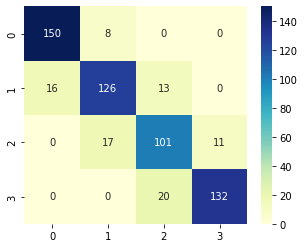

In [62]:
# Accuracy of the model
dtTrain = dtBest.score(x_train, y_train)*100
dtTest = dtBest.score(x_test, y_test)*100
dtCon = confusion_matrix(y_test, y_dt)
print(classification_report(y_test, y_dt))
plt.figure(figsize=(5,4))
sns.heatmap(dtCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Decision Tree',dtTest,dtTrain)

### Random Forest

In [63]:
start = time.time()
grid =  GridSearchCV(RandomForestClassifier(), rfParams, cv=5, verbose = 1, n_jobs = -1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameter {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50}
Best Score 0.891047450847986
Time Elapsed:  166.79


In [64]:
# Train the model with the best parameters
rfBest = grid.best_estimator_
rfBest.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=50)

In [65]:
# Predict on test data
y_rf = rfBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_rf], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       158
           1       0.88      0.82      0.85       155
           2       0.79      0.84      0.81       129
           3       0.95      0.89      0.92       152

    accuracy                           0.88       594
   macro avg       0.88      0.88      0.88       594
weighted avg       0.89      0.88      0.88       594



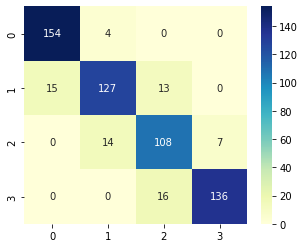

In [66]:
# Accuracy of the model
rfTrain = rfBest.score(x_train, y_train)*100
rfTest = rfBest.score(x_test, y_test)*100
rfCon = confusion_matrix(y_test, y_rf)
print(classification_report(y_test, y_rf))
plt.figure(figsize=(5,4))
sns.heatmap(rfCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Random Forest',rfTest,rfTrain)

### Support Vector Machine

In [67]:
start = time.time()
grid = GridSearchCV(SVC(), svmParams, verbose = 1, n_jobs=-1, scoring='accuracy')
grid.fit(x_train, y_train)
end = time.time()
print('Best Parameter', grid.best_params_)
print('Best Score', grid.best_score_)
print('Time Elapsed: ', round(end - start,2))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameter {'C': 1000}
Best Score 0.961756226787523
Time Elapsed:  0.38


In [68]:
# Train the model with the best parameters
svmBest = grid.best_estimator_
svmBest.fit(x_train, y_train)

SVC(C=1000)

In [69]:
# Predict on test data
y_svm = svmBest.predict(x_test)
pd.DataFrame(np.c_[y_test, y_svm], columns=['Actual', 'Predicted']).head()

,Actual,Predicted
0,3,3
1,0,0
2,0,0
3,3,3
4,1,1


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.96      0.97      0.96       155
           2       0.97      0.96      0.96       129
           3       0.98      0.99      0.99       152

    accuracy                           0.97       594
   macro avg       0.97      0.97      0.97       594
weighted avg       0.97      0.97      0.97       594



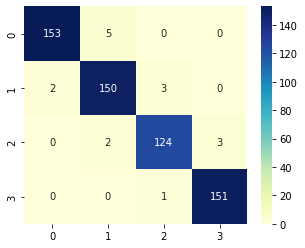

In [70]:
# Accuracy of the model
svmTrain = svmBest.score(x_train, y_train)*100
svmTest = svmBest.score(x_test, y_test)*100
svmCon = confusion_matrix(y_test, y_svm)
print(classification_report(y_test, y_svm))
plt.figure(figsize=(5,4))
sns.heatmap(svmCon, annot=True, fmt='g', cmap='YlGnBu')
eval('Support Vector Machine',svmTest,svmTrain)

### Best Method (Filtered)

In [71]:
# Evaluate the models
result2 = pd.DataFrame({'Model': MODEL, 'Test Accuracy': TEST, 'Train Accuracy': TRAIN})
result2.sort_values(by='Test Accuracy', ascending=False)

,Model,Test Accuracy,Train Accuracy
2,Support Vector Machine,97.31,98.85
1,Random Forest,88.38,99.86
0,Decision Tree,85.69,94.59


## Evaluation

In [72]:
print('Full Feature Model :')
print(result1)
print('Reduced Feature Model :')
print(result2)

Full Feature Model :
                    Model  Test Accuracy  Train Accuracy
0           Decision Tree          84.34           91.85
1           Random Forest          86.70           99.93
2  Support Vector Machine          97.31           98.63
Reduced Feature Model :
                    Model  Test Accuracy  Train Accuracy
0           Decision Tree          85.69           94.59
1           Random Forest          88.38           99.86
2  Support Vector Machine          97.31           98.85
